# MovingPandas

https://github.com/anitagraser/movingpandas

In [1]:
import pandas as pd
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from trajectory import Trajectory 

In [2]:
df = pd.DataFrame([
  {'geometry':Point(0,0), 't':datetime(2018,1,1,12,0,0)},
  {'geometry':Point(6,0), 't':datetime(2018,1,1,12,6,0)},
  {'geometry':Point(6,6), 't':datetime(2018,1,1,12,10,0)},
  {'geometry':Point(9,9), 't':datetime(2018,1,1,12,15,0)}
]).set_index('t')
geo_df = GeoDataFrame(df, crs={'init': '31256'})
traj = Trajectory(1,geo_df)

print(traj)

Trajectory 1 (2018-01-01 12:00:00 to 2018-01-01 12:15:00) | Size: 4 | Length: 16.2m
Bounds: (0.0, 0.0, 9.0, 9.0)
LINESTRING (0 0, 6 0, 6 6, 9 9)


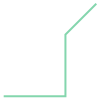

In [3]:
traj.to_linestring()

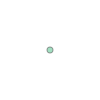

In [4]:
traj.get_position_at(datetime(2018,1,1,12,6,0))    

In [5]:
print(traj.get_position_at(datetime(2018,1,1,12,6,0)))

POINT (6 0)


In [6]:
print(traj.get_segment_between(datetime(2018,1,1,12,6,0),datetime(2018,1,1,12,12,0)))

Trajectory 1 (2018-01-01 12:06:00 to 2018-01-01 12:10:00) | Size: 2 | Length: 6.0m
Bounds: (6.0, 0.0, 6.0, 6.0)
LINESTRING (6 0, 6 6)


In [7]:
xmin, xmax, ymin, ymax = 2, 8, -10, 5
polygon = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)])

intersection = traj.clip(polygon)

print(intersection[0])

Trajectory 1_0 (2018-01-01 12:02:00 to 2018-01-01 12:09:20) | Size: 3 | Length: 9.0m
Bounds: (2.0, 0.0, 6.0, 5.0)
LINESTRING (2 0, 6 0, 6 5)


/srv/conda/lib/python3.6/site-packages/geopandas/base.py:76: UserWarning: Cannot generate spatial index: Missing package `rtree`.
  warn("Cannot generate spatial index: Missing package `rtree`.")
/home/jovyan/overlay.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  row0['geometry'] = range.pt_0
/home/jovyan/overlay.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  rown['geometry'] = range.pt_n


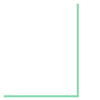

In [8]:
intersection[0].to_linestring()

## Trajectory data from GeoPackage

In [9]:
!wget https://github.com/anitagraser/movingpandas/raw/master/demo/demodata_geolife.gpkg

--2019-04-25 20:48:02--  https://github.com/anitagraser/movingpandas/raw/master/demo/demodata_geolife.gpkg
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/anitagraser/movingpandas/master/demo/demodata_geolife.gpkg [following]
--2019-04-25 20:48:02--  https://raw.githubusercontent.com/anitagraser/movingpandas/master/demo/demodata_geolife.gpkg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 991232 (968K) [application/octet-stream]
Saving to: ‘demodata_geolife.gpkg’

demodata_geolife.gp 100%[===================>] 968.00K  --.-KB/s    in 0.06s   

2019-04-25 20:48:02 (15.6 MB/s) - ‘de

In [10]:
!ls

demo		       overlay.py	 tests
demodata_geolife.gpkg  __pycache__	 trajectory_prediction_evaluator.py
geometry_utils.py      README.md	 trajectory_predictor.py
getting_started.ipynb  requirements.txt  trajectory.py
__init__.py	       runtime.txt	 trajectory_sampler.py
LICENSE		       sandbox


In [11]:
t_start = datetime.now()
df = read_file('demodata_geolife.gpkg')
df['t'] = pd.to_datetime(df['t'])
df = df.set_index('t')
print("Finished reading {} rows in {}".format(len(df),datetime.now() - t_start))

t_start = datetime.now()
trajectories = []
for key, values in df.groupby(['trajectory_id']):
    trajectory = Trajectory(key, values)
    print(trajectory)
    trajectories.append(trajectory)
print("Finished creating {} trajectories in {}".format(len(trajectories),datetime.now() - t_start))

Finished reading 5908 rows in 0:00:00.278573
Trajectory 1 (2008-12-11 04:42:14 to 2008-12-11 05:15:46) | Size: 466 | Length: 6210.1m
Bounds: (116.385602, 39.862378, 116.393553, 39.898723)
LINESTRING (116.391305 39.898573, 116.391317 39.898617, 116.390928 39.898613, 116.390833 39.898635, 
Trajectory 2 (2009-06-29 07:02:25 to 2009-06-29 11:13:12) | Size: 897 | Length: 38728.7m
Bounds: (116.319212, 39.971703, 116.592616, 40.082514)
LINESTRING (116.590957 40.071961, 116.590905 40.072007, 116.590879 40.072027, 116.590915 40.072004, 
Trajectory 3 (2009-02-04 04:32:53 to 2009-02-04 11:20:12) | Size: 1810 | Length: 12739.2m
Bounds: (116.332706, 39.897023, 116.387307, 39.927949)
LINESTRING (116.385689 39.899773, 116.385654 39.899651, 116.385548 39.899699, 116.385527 39.899632, 
Trajectory 4 (2009-03-10 10:36:45 to 2009-03-10 12:01:07) | Size: 1864 | Length: 14357.6m
Bounds: (116.327347, 39.896671, 116.389611, 39.927947)
LINESTRING (116.388053 39.903418, 116.388042 39.9035, 116.388035 39.903467,

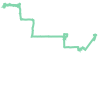

In [29]:
trajectories[3].to_linestring()

In [14]:
xmin, xmax, ymin, ymax = 116.3685035,116.3702945,39.904675,39.907728
polygon = Polygon([(xmin,ymin), (xmin,ymax), (xmax,ymax), (xmax,ymin), (xmin,ymin)])

intersections = []
for key, values in df.groupby(['trajectory_id']):
    traj = Trajectory(key, values)
    for intersection in traj.clip(polygon):
        intersections.append(intersection)
print("Found {} intersections".format(len(intersections)))

Found 3 intersections


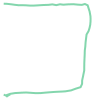

In [20]:
intersections[2].to_linestring()